In [2]:
# ----------------------------
# Andres Graterol 
# EEL 5678 
# 4031393
# ---------------------------
# NN solution for the Concrete Cracks classification 
# ---------------------------
import os
import warnings
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

#gpus = tf.config.list_physical_devices('GPU')
#if gpus:
#  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#  try:
#    tf.config.set_logical_device_configuration(
#        gpus[0],
#        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#    logical_gpus = tf.config.list_logical_devices('GPU')
#    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
#    print(e)

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found. Please check tensorflow setup")
else:
    print(tf.test.gpu_device_name())
print(tf.test.is_built_with_cuda())

True


C:\Users\angel\AppData\Local\Temp\ipykernel_17332\2610885201.py:33: UserWarning: No GPU found. Please check tensorflow setup
  warnings.warn("No GPU found. Please check tensorflow setup")


In [3]:
# TODO: See if want to reduce image size or perform PCA
def data_preprocessing(negative_pics, positive_pics):
    # Class 0 => No cracks 
    # Class 1 => Cracks 

    # Before reshape => (20000, 227, 227)
    # Want => (20000, 51529, 1)
    negative_images = []

    # Iterate over the folder with no cracks  
    for picture in os.scandir(negative_pics):
        if picture.is_file():
            pic_path = negative_pics + '/' + picture.name
            image = cv2.imread(pic_path)
            # Remove 3 channels 
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Each image is (227, 227, 3)
            # Grayscale => (227, 227, 1)
            data = np.asarray(gray_image)
            data = data.reshape((227*227))
            # Add extra last column to help with labeling
            data = np.append(data, 0)
            negative_images.append(data)

    positive_images = []

    # Iterative over the folder with cracks
    for picture in os.scandir(positive_pics):
        if picture.is_file():
            pic_path = positive_pics + '/' + picture.name
            image = cv2.imread(pic_path)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            data = np.asarray(gray_image)
            data = data.reshape((227*227))
            data = np.append(data, 1)
            positive_images.append(data)

    all_images = np.concatenate((negative_images, positive_images))

    # TODO: Seed the shuffle??
    np.random.shuffle(all_images)
    # 75 and 25 split (30000) and (10000)
    x_train, x_test = all_images[:30000], all_images[30000:]

    y_train = []
    y_test = []

    for point in x_train:
        if (point[-1] == 0):
            # OHE for class 0
            y_train.append([1, 0])
        if (point[-1] == 1):
            # OHE for class 1
            y_train.append([0, 1])

    # TODO: See if this needs to be done before reshaping!!!
    # drop the label point 
    x_train = np.delete(x_train, obj=-1, axis=1)
    x_train = x_train.astype('float32')
    # Normalize the data
    x_train /= 255
    x_train = x_train[:, :, np.newaxis]

    for point in x_test:
        if (point[-1] == 0):
            y_test.append([1, 0])
        if (point[-1] == 1):
            y_test.append([0, 1])
        
    # drop the label point 
    x_test = np.delete(x_test, obj=-1, axis=1)
    x_test = x_test.astype('float32')
    x_test /= 255
    x_test = x_test[:, :, np.newaxis]

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)

    return (x_train, y_train), (x_test, y_test)

In [4]:
negative_pics = 'ConcreteCracks/Negative'
positive_pics = 'ConcreteCracks/Positive'

(x_train, y_train), (x_test, y_test) = data_preprocessing(negative_pics, positive_pics)

print("Shape of x_train", x_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of x_test", x_test.shape)
print("Shape of y_test", y_test.shape)

Shape of x_train (30000, 51529, 1)
Shape of y_train (30000, 2)
Shape of x_test (10000, 51529, 1)
Shape of y_test (10000, 2)


In [7]:
class ReportErrorCallback(keras.callbacks.Callback):
    def __init__(self, x_train, y_train, x_test, y_test, training_error_list, testing_error_list):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.training_error_list = training_error_list
        self.testing_error_list = testing_error_list 
    
    def on_epoch_end(self, epoch, logs=None):
        train_error_mse = self.model.evaluate(self.x_train, self.y_train)[1]
        self.training_error_list.append(train_error_mse)
        test_error_mse = self.model.evaluate(self.x_test, self.y_test)[1]
        self.testing_error_list.append(test_error_mse)

Epoch 1/10
844/844 [==============================] - 359s 424ms/step - loss: 1.3461 - accuracy: 0.7709 - val_loss: 0.4193 - val_accuracy: 0.8570
Epoch 2/10
844/844 [==============================] - 341s 405ms/step - loss: 0.4030 - accuracy: 0.8443 - val_loss: 1.0331 - val_accuracy: 0.7007
Epoch 3/10
844/844 [==============================] - 339s 402ms/step - loss: 0.3916 - accuracy: 0.8501 - val_loss: 0.3220 - val_accuracy: 0.8903
Epoch 4/10
844/844 [==============================] - 336s 399ms/step - loss: 0.3457 - accuracy: 0.8740 - val_loss: 0.3225 - val_accuracy: 0.8917
Epoch 5/10
844/844 [==============================] - 345s 409ms/step - loss: 0.3466 - accuracy: 0.8702 - val_loss: 0.4133 - val_accuracy: 0.8150
Epoch 6/10
844/844 [==============================] - 372s 440ms/step - loss: 0.3440 - accuracy: 0.8708 - val_loss: 0.3780 - val_accuracy: 0.8633
Epoch 7/10
844/844 [==============================] - 342s 405ms/step - loss: 0.3254 - accuracy: 0.8823 - val_loss: 0.3209 -

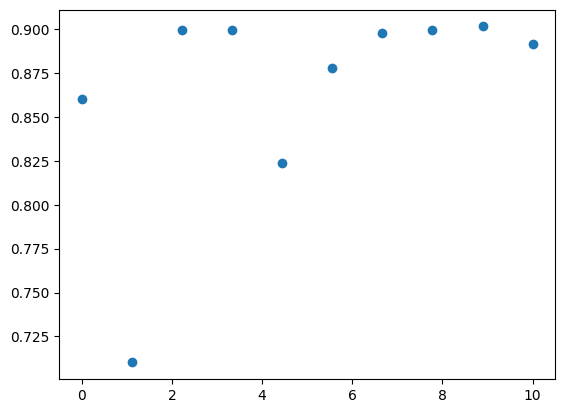

(10,)
Testing Error per epoch


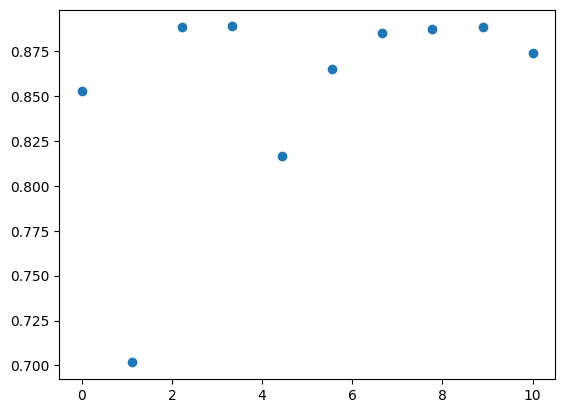

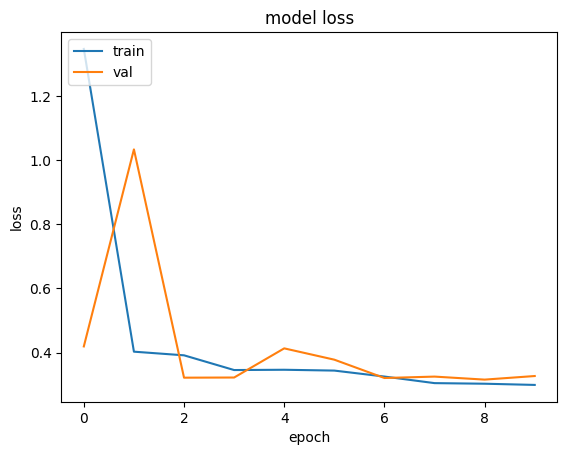

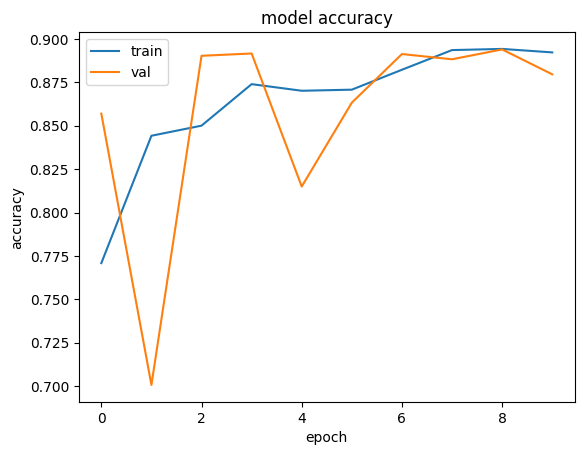

In [13]:
epochs = 10

# One hidden layer NN
NN_1layer = tf.keras.Sequential()

hidden_layer = tf.keras.layers.Dense(units=16, activation='relu')
NN_1layer.add(hidden_layer)

flatten_layer = tf.keras.layers.Flatten()
NN_1layer.add(flatten_layer)

output_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')
NN_1layer.add(output_layer)

NN_1layer.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

training_error_list = []
testing_error_list = []
NN_history = NN_1layer.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=32, callbacks=[ReportErrorCallback(x_train, y_train, x_test, y_test, training_error_list, testing_error_list)])

NN_1layer.summary()

train_info = NN_1layer.evaluate(x_train, y_train)
test_info = NN_1layer.evaluate(x_test, y_test)
print(f"Training accuracy: {train_info[1]*100}% ; Testing accuracy: {test_info[1]*100}%")

# TODO: Make this into a visualization function!
# Plot the mse errors
x = np.linspace(0, epochs, epochs)
print(np.array(training_error_list).shape)
print("Training Error per epoch")
plt.scatter(x, training_error_list)
plt.show()
print(np.array(testing_error_list).shape)
print("Testing Error per epoch")
plt.scatter(x, testing_error_list)
plt.show()

# Plot the training and validation loss
plt.plot(NN_history.history['loss'])
plt.plot(NN_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation accuracy
plt.plot(NN_history.history['accuracy'])
plt.plot(NN_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Start with a CNN 
CNN_model = tf.keras.Sequential()

# Convolutional layer 
# TODO: Find out how many units I should be using in this first parameter
#       Apparently a 3x3 kernel is the optimal
#       Or a 1x3 followed by a 3x1 in another conv2d layer 
# TODO: Find out the optimal number of strides
#       And the optimal number of strides as well
#       Apparently relu is the best activation 
conv_layer = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=(227, 227, 1))
CNN_model.add(conv_layer)

# Max pooling layer 
# TODO: Find optimum pool size 
maxpool_layer = tf.keras.layers.MaxPool2D(pool_size=(4,4))
CNN_model.add(maxpool_layer)

# Flatten layer 
# TODO: Find use of flatten layer
#       Find the optimum number of units 
flatten_layer = tf.keras.layers.Dense(units=100, activation='relu')
CNN_model.add(flatten_layer)

# Add two dense layers 
# TODO: Find use of dense layers 
#       And optimum number of layers if decide to keep 
dense_layer1 = tf.keras.layers.Dense(units=100, activation='relu')
CNN_model.add(dense_layer1)
dense_layer2 = tf.keras.layers.Dense(units=100, activation='relu')
CNN_model.add(dense_layer2)

# Add output layer
# TODO: Find the right output activation 
output_layer = tf.keras.layers.Dense(units=2, activation='softmax')
CNN_model.add(output_layer)

# Print out a summary of the model 
CNN_model.summary()

# Compile the model 
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Train using 100 epochs and a batch of 100
# TODO: Possibly increase the batch size? Find the optimal amount 
CNN_model.fit(x_train, y_train, epochs=100, batch_size=100)

train_info = CNN_model.evaluate(x_train, y_train)
test_info = CNN_model.evaluate(x_test, y_test)
print(f"Training accuracy: {train_info[1]*100}% ; Testing accuracy: {test_info[1]*100}%")